In [28]:
#importing libraries
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import warnings
import torch.optim as optim

%matplotlib inline


In [29]:
def create_data_loaders(image_type , image_dir = 'image_data' , img_size = 128 , batch_size = 16,num_workers = 0):
    
    ''' This function returns dataloaders for the given type of images(summer/winter) which are resized to 128x128x3 and be converted into tensors'''
    
    transform = transforms.Compose([transforms.Resize(img_size) ,transforms.ToTensor()])
    
    #getting the training and testing directories
    train_dir = os.path.join(image_dir , image_type )
    test_dir = os.path.join(image_dir , 'test_{}'.format(image_type))
    
    #defining datasets using image_folder
    train_dataset = dset.ImageFolder(train_dir , transform)
    test_dataset = dset.ImageFolder(test_dir , transform)
    
    #Defining the dataloaders
    train_loader = DataLoader(train_dataset , batch_size = batch_size , shuffle = True , num_workers = num_workers)
    
    test_loader = DataLoader(test_dataset , batch_size = batch_size , shuffle = False , num_workers = num_workers)
    
    return train_loader , test_loader

    

In [30]:
#Creating train and test loaders for images from domains X and Y
train_loader_X , test_loader_X = create_data_loaders(image_type = 'summer')
train_loader_Y , test_loader_Y = create_data_loaders(image_type = 'winter')

print(len(train_loader_X) , len(test_loader_X))

77 20


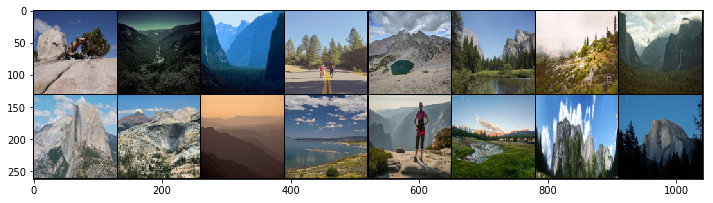

In [31]:
#Visualizing some images from dataset

def imshow(img):
    
    nimg = img.numpy()
    plt.imshow(np.transpose(nimg ,(1,2,0) ))
    

data_iter = iter(train_loader_X) #summer images
imgs , _  = data_iter.next()

fig = plt.figure(figsize = (12,8))
imshow(torchvision.utils.make_grid(imgs))

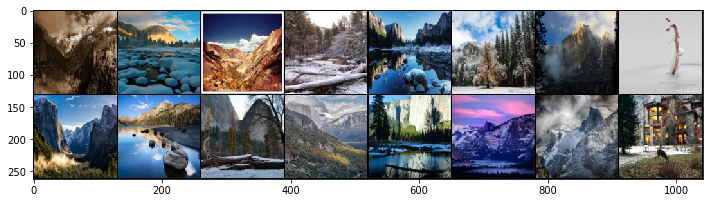

In [32]:
#images from domain Y i.e winter

data_iter_Y = iter(train_loader_Y)
imgs_Y , _  = data_iter_Y.next()

fig = plt.figure(figsize = (12,8))
imshow(torchvision.utils.make_grid(imgs_Y))

In [33]:
#def scale_images(img , feature_range = (-1,1)):
    #''' This functions takes input an images and returns that image with pixel values between -1 and 1'''
    
    #max , min = feature_range
    
    #img = img*(max - min) + min
    #return img

In [34]:
def Conv(in_channels , out_channels , kernel_size , stride = 2 , padding = 1 , batch_norm = True):
     
        ''' Crates convolutional Layers with optional Batch normalization'''
        layers = []
        conv_layer = nn.Conv2d(in_channels = in_channels , out_channels = out_channels , kernel_size = kernel_size , stride = stride , padding = padding , bias = False)
        layers.append(conv_layer)
        
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        return nn.Sequential(*layers)


In [35]:
#Defining the discriminator architecture


class Discriminator(nn.Module):
    
        def __init__(self , conv_dim = 64):
            super(Discriminator , self).__init__()
            self.conv1 = Conv(3 , conv_dim , 4 , batch_norm = False)
            self.conv2 = Conv(conv_dim , conv_dim*2 , 4) #(32 ,32,128)
            self.conv3 = Conv(conv_dim*2 , conv_dim*4 , 4) #(16 ,16,256)
            self.conv4 = Conv(conv_dim*4 , conv_dim*8 , 4) #(8 ,8,512)
            
            self.conv5 = Conv(conv_dim*8 , 1 , 4 , stride = 1 , batch_norm = False)
            
        def forward(self , x):
            
            out = F.relu(self.conv1(x))
            out = F.relu(self.conv2(out))
            out = F.relu(self.conv3(out))
            out = F.relu(self.conv4(out))
            
            out = self.conv5(out)
            return out

In [36]:
class residual_blocks(nn.Module):
    ''' This class defines a residual block'''
    
    def __init__(self , conv_dim):
        super(residual_blocks , self).__init__()
        
        self.conv1 = Conv(in_channels = conv_dim ,out_channels = conv_dim , kernel_size = 3 , stride = 1 , padding = 1 , batch_norm = True )
        self.conv2 = Conv(in_channels = conv_dim , out_channels = conv_dim , kernel_size = 3 , stride = 1 , padding = 1 , batch_norm = True)
        
    def forward(self , x):
        op1 = F.relu(self.conv1(x))
        op2 = x + self.conv2(op1)
        return op2

In [37]:
def deConv(in_channels , out_channels , kernel_size , stride = 2 , padding = 1 , batch_norm = True):
     
        ''' Creates transpose convolutional Layers with optional Batch normalization'''
        layers = []
        conv_layer = nn.ConvTranspose2d(in_channels = in_channels , out_channels = out_channels , kernel_size = kernel_size , stride = stride , padding = padding , bias = False)
        layers.append(conv_layer)
        
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        return nn.Sequential(*layers)

In [38]:
class Generator(nn.Module):
    
    def __init__(self , conv_dim = 64 , res_blocks = 6):
        super(Generator , self).__init__()
        
        
        #defining the encoder part of the network
        self.conv1 = Conv(3 , conv_dim , 4)
        self.conv2 = Conv(conv_dim , conv_dim*2 , 4)
        self.conv3 = Conv(conv_dim*2 , conv_dim*4 , 4)
        
        
        #Adding residual layers
        res_layers = []
        for layers in range(res_blocks):
            res_layers.append(residual_blocks(conv_dim*4))
        
        self.residual_layers = nn.Sequential(*res_layers)
        
        #defining decoder part of the generator
        self.deconv1 = deConv(conv_dim*4 , conv_dim*2 , 4)
        self.deconv2 = deConv(conv_dim*2 , conv_dim , 4)
        self.deconv3 = deConv(conv_dim , 3 , 4 ,batch_norm = False)
        
        
    def forward(self , x):
        
        ''' Given an image x as input returns the transformed image'''
        op = F.relu(self.conv1(x))
        op = F.relu(self.conv2(op))
        op = F.relu(self.conv3(op))
        
        op = self.residual_layers(op)
        
        op = F.relu(self.deconv1(op))
        op = F.relu(self.deconv2(op))
        
        op = F.tanh(self.deconv3(op))
        return op
        

In [39]:
def create_models(g_conv_dim = 64 , d_conv_dim = 64 , n_res_blocks = 6):
    
    '''builds the generator and discriminators'''
    
    #Generators
    G_XtoY = Generator(conv_dim = g_conv_dim , res_blocks = n_res_blocks)
    G_YtoX = Generator(conv_dim = g_conv_dim , res_blocks = n_res_blocks)
    
    #Discriminators
    D_X = Discriminator(conv_dim = g_conv_dim )
    D_Y = Discriminator(conv_dim = g_conv_dim)
    
    if torch.cuda.is_available():
        
        #device = torch.device("cuda : 0")
        G_XtoY.cuda()
        G_YtoX.cuda()
        D_X.cuda()
        D_Y.cuda()
        
        print("Models moved to GPU")
    
    else:
        print("Only Cpu Available")
       
    return G_XtoY , G_YtoX ,D_X , D_Y
        

In [40]:
def print_model_arch(model , model_name):
    
    '''This functions prints the network architecture'''
    print(model_name)
    print()
    print("******************************************************************")
    print(model)
    print()
    print("******************************************************************")
    print()
    
    

In [41]:
#Creating models and prinitng them
G_XtoY , G_YtoX , D_X , D_Y = create_models()
model_list = [G_XtoY , G_YtoX , D_X , D_Y]
model_name_list = [ 'G_XtoY' , 'G_YtoX' , 'D_X' , 'D_Y']

#Printing the archs
for model , name in zip(model_list , model_name_list):
    print_model_arch(model , name)

Models moved to GPU
G_XtoY

******************************************************************
Generator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (residual_layers): Sequential(
    (0): residual_blocks(
      (conv1): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )


In [42]:
#Defining the losses

def real_mse_loss(D_out):
    
    #How close is the produced output from being real
    return torch.mean((D_out - 1)**2)

def fake_mse_loss(D_out):
    
    #How close is the produced output from being fake
    return torch.mean((D_out - 0)**2)

def cycle_cons_loss(real_im , recons_im , lambda_wt):
    
    return lambda_wt * (torch.mean(torch.abs(real_im - recons_im)))



In [43]:
#function to save the models at checkpoints

def save_at_checkpoints(iteration , G_XtoY , G_YtoX , D_X , D_Y , save_dir = 'model_save'):
    
    ''' Saves the parameters of both generators and discriminators'''
    G_XtoY_path = os.path.join(save_dir , 'G_XtoY.pkl')
    G_YtoX_path = os.path.join(save_dir , 'G_YtoX.pkl')
    D_X_path = os.path.join(save_dir , 'D_X.pkl')
    D_Y_path = os.path.join(save_dir , 'D_Y.pkl')
    
    torch.save(G_XtoY.state_dict() , G_XtoY_path)
    torch.save(G_YtoX.state_dict() , G_YtoX_path)
    torch.save(D_X.state_dict() , D_X_path)
    torch.save(D_Y.state_dict() , D_Y_path)

In [44]:
def merge_images(sources , targets , batch_size= 16):
    
    ''' This function creates a grid consisting of columns  , first column contains source images and second column contain the generated images'''
   
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    merged = merged.transpose(1, 2, 0)
    return merged

In [45]:
from skimage.util import img_as_ubyte
def convert_to_data(x):
    '''Converts the variable to numpy'''
    
    if torch.cuda.is_available():
         
            x = x.cpu()
    
    
    return x.data.numpy()

In [52]:
from torch.autograd import Variable
def to_var(x):
    """Converts numpy to variable."""
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [54]:
import matplotlib
def save_samples(iteration , fixed_Y , fixed_X , G_YtoX , G_XtoY , batch_size = 16 , save_dir = 'gen_images'):
    
    '''Saves generated imaages from both the samples  X--> Y and Y-->X'''
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    fake_X = G_YtoX(fixed_Y.to(device))
    fake_Y = G_XtoY(fixed_X.to(device))

    X , fake_X = convert_to_data(fixed_X) , convert_to_data(fake_X)
    Y , fake_Y = convert_to_data(fixed_Y) , convert_to_data(fake_Y)
    
    merged = merge_images(X , fake_X , batch_size)
    path = os.path.join(save_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    print('Saved {}'.format(path))
    matplotlib.image.imsave(path , merged)
    
    
    merged = merge_images(Y, fake_X, batch_size)
    path = os.path.join(save_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    print('Saved {}'.format(path))
    matplotlib.image.imsave(path , merged)
    
    
    

In [55]:


#Defining the optimizers

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

gen_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())

g_optimizer = optim.Adam(gen_params , lr , betas = (beta1 , beta2))
d_x_optimizer = optim.Adam(D_X.parameters() , lr , betas = (beta1 , beta2))
d_y_optimizer = optim.Adam(D_Y.parameters() , lr , betas = (beta1 , beta2))


In [56]:
#Creating the training function

import time
def train_models(train_loader_X , train_loader_Y , test_loader_X , test_loader_Y , n_epochs):
    
    print_every=10
    
   
    # keep track of losses over time
    losses = []
    
    test_iter_X = iter(test_loader_X)
    test_iter_Y = iter(test_loader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = to_var(test_iter_X.next()[0])
    fixed_Y = to_var(test_iter_Y.next()[0])
    #fixed_X = scale_images(fixed_X) # make sure to scale to a range -1 to 1
    #fixed_Y = scale_images(fixed_Y)

    # batches per epoch
    iter_X = iter(train_loader_X)
    iter_Y = iter(train_loader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        start = time.time()
        if epoch % batches_per_epoch == 0:
            iter_X = iter(train_loader_X)
            iter_Y = iter(train_loader_Y)

        images_X, _ = iter_X.next()
        images_X = to_var(images_X) # make sure to scale to a range -1 to 1

        images_Y, _ = iter_Y.next()
        images_Y = to_var(images_Y)
        
        # move images to GPU if available (otherwise stay on CPU)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)


        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        ##   First: D_X, real and fake loss components   ##

        # Train with real images
        d_x_optimizer.zero_grad()

        # 1. Compute the discriminator losses on real images
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        
        # Train with fake images
        
        # 2. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 3. Compute the fake loss for D_X
        out_x = D_X(fake_X)
        D_X_fake_loss = fake_mse_loss(out_x)
        

        # 4. Compute the total loss and perform backprop
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()

        
        ##   Second: D_Y, real and fake loss components   ##
        
        # Train with real images
        d_y_optimizer.zero_grad()
        
        # 1. Compute the discriminator losses on real images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # Train with fake images

        # 2. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 3. Compute the fake loss for D_Y
        out_y = D_Y(fake_Y)
        D_Y_fake_loss = fake_mse_loss(out_y)

        # 4. Compute the total loss and perform backprop
        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        ## First: generate fake X images and reconstructed Y images    ##
        g_optimizer.zero_grad()

        # 1. Generate fake images that look like domain X based on real images in domain Y
        fake_X = G_YtoX(images_Y)

        # 2. Compute the generator loss based on domain X
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        # 3. Create a reconstructed y
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_cons_loss(images_Y, reconstructed_Y, lambda_wt=10)


        ## Second: generate fake Y images and reconstructed X images    ##

        # 1. Generate fake images that look like domain Y based on real images in domain X
        fake_Y = G_XtoY(images_X)

        # 2. Compute the generator loss based on domain Y
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        # 3. Create a reconstructed x
        # 4. Compute the cycle consistency loss (the reconstruction loss)
        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_cons_loss(images_X, reconstructed_X, lambda_wt=10)

        # 5. Add up all generator and reconstructed losses and perform backprop
        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()


        # Print the log info
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))

            
            print("Time per batch : {:6.4f}".format(time.time() - start))
        sample_every=100
        # Save the generated samples
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16)
            G_YtoX.train()
            G_XtoY.train()

        checkpoint_every=1000
        #Save the model parameters
        if epoch % checkpoint_every == 0:
             save_at_checkpoints(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses
            
            
        
        
        

In [58]:
n_epochs = 1000
losses = train_models(train_loader_X , train_loader_Y , test_loader_X , test_loader_Y , n_epochs = n_epochs)


Epoch [   10/ 1000] | d_X_loss: 0.3382 | d_Y_loss: 0.5819 | g_total_loss: 2.8913
Time per batch : 1.2936
Epoch [   20/ 1000] | d_X_loss: 0.2908 | d_Y_loss: 0.3355 | g_total_loss: 2.9001
Time per batch : 1.2968
Epoch [   30/ 1000] | d_X_loss: 0.3886 | d_Y_loss: 0.4902 | g_total_loss: 2.6181
Time per batch : 1.3044
Epoch [   40/ 1000] | d_X_loss: 0.4127 | d_Y_loss: 0.4000 | g_total_loss: 2.6344
Time per batch : 1.2965
Epoch [   50/ 1000] | d_X_loss: 0.8471 | d_Y_loss: 0.4215 | g_total_loss: 2.3218
Time per batch : 1.3259
Epoch [   60/ 1000] | d_X_loss: 0.4500 | d_Y_loss: 0.5447 | g_total_loss: 3.3591
Time per batch : 1.3481
Epoch [   70/ 1000] | d_X_loss: 0.4533 | d_Y_loss: 0.5333 | g_total_loss: 2.9378
Time per batch : 1.3277
Epoch [   80/ 1000] | d_X_loss: 0.4738 | d_Y_loss: 0.4224 | g_total_loss: 2.4281
Time per batch : 1.3434
Epoch [   90/ 1000] | d_X_loss: 0.4765 | d_Y_loss: 0.4565 | g_total_loss: 2.7896
Time per batch : 1.3589
Epoch [  100/ 1000] | d_X_loss: 0.4795 | d_Y_loss: 0.40

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved gen_images\sample-000100-Y-X.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [  110/ 1000] | d_X_loss: 0.4940 | d_Y_loss: 0.4503 | g_total_loss: 2.9428
Time per batch : 1.3958
Epoch [  120/ 1000] | d_X_loss: 0.3679 | d_Y_loss: 0.3822 | g_total_loss: 2.6164
Time per batch : 1.3738
Epoch [  130/ 1000] | d_X_loss: 0.4295 | d_Y_loss: 0.4451 | g_total_loss: 2.9448
Time per batch : 1.4019
Epoch [  140/ 1000] | d_X_loss: 0.4075 | d_Y_loss: 0.3842 | g_total_loss: 2.5990
Time per batch : 1.3778
Epoch [  150/ 1000] | d_X_loss: 0.3694 | d_Y_loss: 0.4505 | g_total_loss: 2.4784
Time per batch : 1.3746
Epoch [  160/ 1000] | d_X_loss: 0.4161 | d_Y_loss: 0.3566 | g_total_loss: 2.6500
Time per batch : 1.3747
Epoch [  170/ 1000] | d_X_loss: 0.4952 | d_Y_loss: 0.4211 | g_total_loss: 2.5824
Time per batch : 1.3944
Epoch [  180/ 1000] | d_X_loss: 0.3167 | d_Y_loss: 0.4073 | g_total_loss: 3.2269
Time per batch : 1.4093
Epoch [  190/ 1000] | d_X_loss: 0.3932 | d_Y_loss: 0.3465 | g_total_loss: 2.6765
Time per batch : 1.4060
Epoch [  200/ 1000] | d_X_loss: 0.4129 | d_Y_loss: 0.48

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved gen_images\sample-000200-Y-X.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [  210/ 1000] | d_X_loss: 0.3997 | d_Y_loss: 0.3886 | g_total_loss: 2.5167
Time per batch : 1.3746
Epoch [  220/ 1000] | d_X_loss: 0.3930 | d_Y_loss: 0.4119 | g_total_loss: 2.5057
Time per batch : 1.4322
Epoch [  230/ 1000] | d_X_loss: 0.3621 | d_Y_loss: 0.3787 | g_total_loss: 2.7689
Time per batch : 1.3917
Epoch [  240/ 1000] | d_X_loss: 0.3312 | d_Y_loss: 0.4789 | g_total_loss: 2.3704
Time per batch : 1.4099
Epoch [  250/ 1000] | d_X_loss: 0.3976 | d_Y_loss: 0.7159 | g_total_loss: 3.0333
Time per batch : 1.4166
Epoch [  260/ 1000] | d_X_loss: 0.4043 | d_Y_loss: 0.3641 | g_total_loss: 2.3321
Time per batch : 1.3618
Epoch [  270/ 1000] | d_X_loss: 0.4119 | d_Y_loss: 0.4558 | g_total_loss: 2.5254
Time per batch : 1.4036
Epoch [  280/ 1000] | d_X_loss: 0.4251 | d_Y_loss: 0.3810 | g_total_loss: 2.3655
Time per batch : 1.4065
Epoch [  290/ 1000] | d_X_loss: 0.4168 | d_Y_loss: 0.3394 | g_total_loss: 2.8505
Time per batch : 1.4238
Epoch [  300/ 1000] | d_X_loss: 0.3890 | d_Y_loss: 0.47

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved gen_images\sample-000300-Y-X.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [  310/ 1000] | d_X_loss: 0.8829 | d_Y_loss: 0.3912 | g_total_loss: 2.8139
Time per batch : 1.4031
Epoch [  320/ 1000] | d_X_loss: 0.4203 | d_Y_loss: 0.2765 | g_total_loss: 3.2725
Time per batch : 1.3919
Epoch [  330/ 1000] | d_X_loss: 0.8614 | d_Y_loss: 0.4173 | g_total_loss: 3.2299
Time per batch : 1.4175
Epoch [  340/ 1000] | d_X_loss: 0.3850 | d_Y_loss: 0.4807 | g_total_loss: 2.2616
Time per batch : 1.3994
Epoch [  350/ 1000] | d_X_loss: 0.4275 | d_Y_loss: 0.3429 | g_total_loss: 2.8526
Time per batch : 1.3804
Epoch [  360/ 1000] | d_X_loss: 0.3902 | d_Y_loss: 0.3847 | g_total_loss: 2.4303
Time per batch : 1.3900
Epoch [  370/ 1000] | d_X_loss: 0.3110 | d_Y_loss: 0.3645 | g_total_loss: 2.6402
Time per batch : 1.3957
Epoch [  380/ 1000] | d_X_loss: 0.4007 | d_Y_loss: 0.4833 | g_total_loss: 2.8818
Time per batch : 1.3902
Epoch [  390/ 1000] | d_X_loss: 0.4353 | d_Y_loss: 0.3310 | g_total_loss: 2.8750
Time per batch : 1.4130
Epoch [  400/ 1000] | d_X_loss: 0.3109 | d_Y_loss: 0.41

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved gen_images\sample-000400-Y-X.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [  410/ 1000] | d_X_loss: 0.3375 | d_Y_loss: 0.5808 | g_total_loss: 2.6432
Time per batch : 1.3942
Epoch [  420/ 1000] | d_X_loss: 0.3817 | d_Y_loss: 0.3073 | g_total_loss: 2.5966
Time per batch : 1.4042
Epoch [  430/ 1000] | d_X_loss: 0.3491 | d_Y_loss: 0.3442 | g_total_loss: 2.9551
Time per batch : 1.4097
Epoch [  440/ 1000] | d_X_loss: 0.3747 | d_Y_loss: 0.2972 | g_total_loss: 2.8000
Time per batch : 1.4030
Epoch [  450/ 1000] | d_X_loss: 0.3179 | d_Y_loss: 0.4000 | g_total_loss: 3.0081
Time per batch : 1.4065
Epoch [  460/ 1000] | d_X_loss: 0.4125 | d_Y_loss: 0.3296 | g_total_loss: 2.9156
Time per batch : 1.4004
Epoch [  470/ 1000] | d_X_loss: 0.4440 | d_Y_loss: 0.3582 | g_total_loss: 2.1581
Time per batch : 1.3928
Epoch [  480/ 1000] | d_X_loss: 0.3130 | d_Y_loss: 0.3929 | g_total_loss: 2.6574
Time per batch : 1.4272
Epoch [  490/ 1000] | d_X_loss: 0.2561 | d_Y_loss: 0.2868 | g_total_loss: 2.9184
Time per batch : 1.3902
Epoch [  500/ 1000] | d_X_loss: 0.3969 | d_Y_loss: 0.27

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved gen_images\sample-000500-Y-X.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [  510/ 1000] | d_X_loss: 0.2989 | d_Y_loss: 0.3742 | g_total_loss: 2.9624
Time per batch : 1.4146
Epoch [  520/ 1000] | d_X_loss: 0.7495 | d_Y_loss: 0.7076 | g_total_loss: 3.2360
Time per batch : 1.4040
Epoch [  530/ 1000] | d_X_loss: 0.3787 | d_Y_loss: 0.3330 | g_total_loss: 2.5235
Time per batch : 1.4059
Epoch [  540/ 1000] | d_X_loss: 0.2178 | d_Y_loss: 0.3311 | g_total_loss: 3.7885
Time per batch : 1.3902
Epoch [  550/ 1000] | d_X_loss: 0.2350 | d_Y_loss: 0.2871 | g_total_loss: 3.8280
Time per batch : 1.4019
Epoch [  560/ 1000] | d_X_loss: 0.4025 | d_Y_loss: 0.8833 | g_total_loss: 2.6656
Time per batch : 1.4058
Epoch [  570/ 1000] | d_X_loss: 0.2881 | d_Y_loss: 0.3406 | g_total_loss: 2.8320
Time per batch : 1.3902
Epoch [  580/ 1000] | d_X_loss: 0.5064 | d_Y_loss: 0.3197 | g_total_loss: 2.8750
Time per batch : 1.4001
Epoch [  590/ 1000] | d_X_loss: 0.2277 | d_Y_loss: 0.7104 | g_total_loss: 4.1871
Time per batch : 1.4059
Epoch [  600/ 1000] | d_X_loss: 0.3291 | d_Y_loss: 0.29

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved gen_images\sample-000600-Y-X.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [  610/ 1000] | d_X_loss: 0.3289 | d_Y_loss: 0.3731 | g_total_loss: 3.2225
Time per batch : 1.2583
Epoch [  620/ 1000] | d_X_loss: 0.2416 | d_Y_loss: 0.3453 | g_total_loss: 2.4017
Time per batch : 1.4033
Epoch [  630/ 1000] | d_X_loss: 0.3365 | d_Y_loss: 0.2806 | g_total_loss: 2.5363
Time per batch : 1.4085
Epoch [  640/ 1000] | d_X_loss: 0.3516 | d_Y_loss: 0.3528 | g_total_loss: 2.2899
Time per batch : 1.4195
Epoch [  650/ 1000] | d_X_loss: 0.4181 | d_Y_loss: 0.4200 | g_total_loss: 3.4966
Time per batch : 1.3903
Epoch [  660/ 1000] | d_X_loss: 0.3091 | d_Y_loss: 0.4407 | g_total_loss: 2.2586
Time per batch : 1.3902
Epoch [  670/ 1000] | d_X_loss: 0.1260 | d_Y_loss: 0.6634 | g_total_loss: 2.3310
Time per batch : 0.9215
Epoch [  680/ 1000] | d_X_loss: 0.1702 | d_Y_loss: 0.4213 | g_total_loss: 2.9911
Time per batch : 1.4058
Epoch [  690/ 1000] | d_X_loss: 0.3125 | d_Y_loss: 0.3142 | g_total_loss: 2.7804
Time per batch : 1.3903
Epoch [  700/ 1000] | d_X_loss: 0.0556 | d_Y_loss: 0.27

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved gen_images\sample-000700-Y-X.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [  710/ 1000] | d_X_loss: 0.1717 | d_Y_loss: 0.5712 | g_total_loss: 2.3731
Time per batch : 1.3986
Epoch [  720/ 1000] | d_X_loss: 0.5154 | d_Y_loss: 0.2919 | g_total_loss: 3.5356
Time per batch : 1.3987
Epoch [  730/ 1000] | d_X_loss: 0.3759 | d_Y_loss: 0.3858 | g_total_loss: 2.4558
Time per batch : 1.3927
Epoch [  740/ 1000] | d_X_loss: 0.3453 | d_Y_loss: 0.3052 | g_total_loss: 3.0026
Time per batch : 1.4040
Epoch [  750/ 1000] | d_X_loss: 0.3029 | d_Y_loss: 0.3802 | g_total_loss: 2.6985
Time per batch : 1.3896
Epoch [  760/ 1000] | d_X_loss: 0.3362 | d_Y_loss: 0.3729 | g_total_loss: 2.9686
Time per batch : 1.3905
Epoch [  770/ 1000] | d_X_loss: 0.1517 | d_Y_loss: 0.4472 | g_total_loss: 3.7075
Time per batch : 1.4181
Epoch [  780/ 1000] | d_X_loss: 0.2494 | d_Y_loss: 0.3339 | g_total_loss: 2.9413
Time per batch : 1.4059
Epoch [  790/ 1000] | d_X_loss: 0.0631 | d_Y_loss: 0.8623 | g_total_loss: 2.1984
Time per batch : 1.4058
Epoch [  800/ 1000] | d_X_loss: 0.2050 | d_Y_loss: 0.40

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved gen_images\sample-000800-Y-X.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [  810/ 1000] | d_X_loss: 0.2637 | d_Y_loss: 0.3492 | g_total_loss: 3.3618
Time per batch : 1.4177
Epoch [  820/ 1000] | d_X_loss: 0.1055 | d_Y_loss: 0.3172 | g_total_loss: 2.8896
Time per batch : 1.4037
Epoch [  830/ 1000] | d_X_loss: 0.2210 | d_Y_loss: 0.2702 | g_total_loss: 2.7606
Time per batch : 1.4059
Epoch [  840/ 1000] | d_X_loss: 0.3879 | d_Y_loss: 0.3548 | g_total_loss: 3.1315
Time per batch : 1.4058
Epoch [  850/ 1000] | d_X_loss: 0.1558 | d_Y_loss: 0.3294 | g_total_loss: 2.8463
Time per batch : 1.4059
Epoch [  860/ 1000] | d_X_loss: 0.3138 | d_Y_loss: 0.2568 | g_total_loss: 3.7256
Time per batch : 1.3902
Epoch [  870/ 1000] | d_X_loss: 0.1432 | d_Y_loss: 0.3496 | g_total_loss: 3.4407
Time per batch : 1.3920
Epoch [  880/ 1000] | d_X_loss: 0.1228 | d_Y_loss: 0.2906 | g_total_loss: 2.7027
Time per batch : 1.4061
Epoch [  890/ 1000] | d_X_loss: 0.1593 | d_Y_loss: 0.3282 | g_total_loss: 2.9004
Time per batch : 1.4123
Epoch [  900/ 1000] | d_X_loss: 0.0481 | d_Y_loss: 0.36

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved gen_images\sample-000900-Y-X.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [  910/ 1000] | d_X_loss: 0.4214 | d_Y_loss: 0.2950 | g_total_loss: 2.7133
Time per batch : 1.4263
Epoch [  920/ 1000] | d_X_loss: 0.2802 | d_Y_loss: 0.6558 | g_total_loss: 3.1911
Time per batch : 1.4087
Epoch [  930/ 1000] | d_X_loss: 0.0571 | d_Y_loss: 0.2347 | g_total_loss: 2.6113
Time per batch : 1.4060
Epoch [  940/ 1000] | d_X_loss: 0.1732 | d_Y_loss: 0.3801 | g_total_loss: 3.5086
Time per batch : 1.3903
Epoch [  950/ 1000] | d_X_loss: 0.3283 | d_Y_loss: 0.3433 | g_total_loss: 3.0332
Time per batch : 1.3746
Epoch [  960/ 1000] | d_X_loss: 0.0620 | d_Y_loss: 0.3108 | g_total_loss: 2.8482
Time per batch : 1.4058
Epoch [  970/ 1000] | d_X_loss: 0.2094 | d_Y_loss: 0.7939 | g_total_loss: 2.5656
Time per batch : 1.4039
Epoch [  980/ 1000] | d_X_loss: 0.0525 | d_Y_loss: 0.2959 | g_total_loss: 2.9193
Time per batch : 1.4046
Epoch [  990/ 1000] | d_X_loss: 0.6855 | d_Y_loss: 0.3557 | g_total_loss: 2.5618
Time per batch : 1.4044
Epoch [ 1000/ 1000] | d_X_loss: 0.1273 | d_Y_loss: 0.34

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved gen_images\sample-001000-Y-X.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


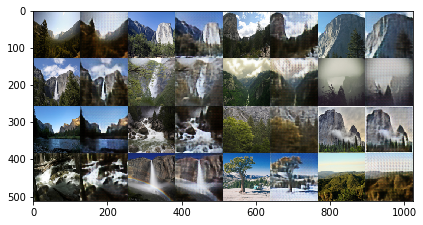

In [29]:
#Results after training for 4000 iterations
import skimage
skimage.io.imshow('gen_images/sample-0004000-X-Y.png')
